## <font color='blue'>**1. Key Parameters**</font>

**Some global parameters:**

- **`ma_window=20`**: Rolling window size for MA (moving average).
- **`slope_points=5`**: Number of points used to compute the slope of MA.
- **`tf="5min"`**: Timeframe used for bar slicing inside `run_alpha` (stop-loss lookback window).
- **`loss_range=-5`**: Stop-loss threshold (in *price points*). If PnL points < `loss_range`, close position.
- **`exit_eps=0.5`**: Tolerance factor used by `near()` when comparing indicators to thresholds.
- **`transaction_fee=0.4`**: Fee subtracted per non-zero PnL step in `calculate_pnl`.

**Pipeline Overview**

1. **`process_data()`** loads ticks and resamples to **1min** and **5min** OHLC.
2. **`add_ma_features()`** adds MA, slope, diff, diff_delta.
3. **`estimate_bands()`** estimates thresholds `{V1, V2, M1, M2}` from data.
4. **`run_alpha()`** runs signal generation with stop-loss logic.
5. **`calculate_pnl()`** calculates gross/net PnL and cumulative PnL.
6. **`plot_ma_charts()`** plots price, MA, diff, diff_delta, slope with thresholds.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ma_window=20
slope_points=5
tf="5min"
loss_range=-5
exit_eps=0.5
transaction_fee=0.4

## <font color='blue'>**2. Some helper functions**</font>

### <font color='green'>**2.1 Estimate bands function**</font>
This estimates thresholds from historical data using quantiles (with optional winsorizing):

- `V1`, `V2`: upper/lower quantiles of `diff` (% deviation from MA)
- `M1`, `M2`: thresholds for `slope` (positive and negative regimes)

In [2]:
def estimate_bands(
    df_5min: pd.DataFrame,
    *,
    ma_window: int = 20,
    slope_points: int = 5,
    diff_q_high: float = 0.80,
    diff_q_low: float = 0.20,
    slope_q_high: float = 0.80,
    slope_q_low: float = 0.20,
    winsor: float = 0.05,
) -> dict:
    # Calculate 20-period moving average on 5-minute data
    ma20 = df_5min['close'].rolling(ma_window).mean().dropna()

    # Align closing prices with ma20 index (because the MA has NaN at the beginning)
    cls_alighed = df_5min['close'].loc[ma20.index]

    # Calculate the price deviation from MA (in percentage)
    diff = (cls_alighed / ma20 - 1.0) * 100.0

    # Calculate the slope of the MA
    slope = (ma20 - ma20.shift(slope_points - 1)) / float(slope_points)

    # Handling infinity and NaN values
    diff = diff.replace([np.inf, -np.inf], np.nan).dropna()
    slope = slope.replace([np.inf, -np.inf], np.nan).dropna()

    # Find and synchronize shared indexes
    common = diff.index.intersection(slope.index)

    # Synchronize the data with the newly found common index
    diff = diff.loc[common]
    slope = slope.loc[common]

    # Winsorize function: Trimming extraneous values ​​on a Pandas Series
    def wins(s: pd.Series) -> pd.Series:
        if winsor <= 0.0:
            return s
        lo = s.quantile(winsor)
        hi = s.quantile(1.0 - winsor)
        return s.clip(lo, hi)

    diff_w = wins(diff)
    V1 = float(diff_w.quantile(diff_q_high))
    V2 = float(diff_w.quantile(diff_q_low))

    slope_w = wins(slope)
    slope_pos = slope_w[slope_w > 0]
    slope_neg = slope_w[slope_w < 0]

    M1 = float(slope_pos.quantile(slope_q_high)) if len(slope_pos) > 5 else float(slope_w.quantile(slope_q_high))
    M2 = float(slope_neg.quantile(slope_q_low)) if len(slope_neg) > 5 else float(slope_w.quantile(slope_q_low))

    M1 = max(M1, 0.0)
    M2 = min(M2, 0.0)

    return {"V1": V1, "V2": V2, "M1": M1, "M2": M2}

### <font color='green'>**2.2 Near function**</font>

`near(x, level)` checks if a value is “close enough” to a threshold.

- If `level == 0`, it uses a fixed tolerance: `exit_eps`
- Otherwise, it uses a relative tolerance: `abs(level) * exit_eps`

In [3]:
def near(x: float, level: float) -> bool:
    tol = exit_eps if level == 0 else max(1e-9, abs(level) * exit_eps)
    return abs(x - level) <= tol

### <font color='green'>**2.3 Add MA features function**</font>

This function adds the core indicators used by the strategy:

- `ma20`: rolling mean of `close` over `ma_window`
- `slope_ma20`: average change of MA over `slope_points`
- `diff`: % deviation of close from MA
- `diff_delta`: first difference of `diff` (momentum of deviation)


In [4]:
def add_ma_features(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty or "close" not in df.columns:
        return df

    out = df.copy()
    out["ma20"] = out["close"].rolling(ma_window).mean()
    out["slope_ma20"] = (out["ma20"] - out["ma20"].shift(slope_points - 1)) / float(slope_points)
    out["diff"] = (out["close"] / out["ma20"] - 1.0) * 100.0
    out["diff_delta"] = out["diff"].diff()

    return out

## <font color='blue'>**3. Process raw data**</font>

`process_data()` loads the CSV, builds a proper timestamp index, then resamples:

- **1-minute OHLC**: `resample('1min').ohlc()`
- **5-minute OHLC**: `resample('5min').ohlc()`

The data used in this function is 41I1FB000. Because the data for the day is insufficient to calculate the MA20, this data file contains raw data collected from 25/11/03 to 25/11/07.

In [5]:
def process_data(file_path: str = "../data/new/41I1FB000_1.csv") -> pd.DataFrame:
    USE_COLS = [
        'crawled_time',
        'time_stamp',
        'gia_khop'
    ]

    df = pd.read_csv(
        file_path,
        usecols=USE_COLS,
        dtype={
            'crawled_time': 'string',
            'time_stamp': 'string'
        }
    )
    df['time_stamp'] = pd.to_datetime(
        df['crawled_time'] + ' ' + df['time_stamp'],
        format='%Y-%m-%d %H:%M:%S.%f',
        errors='coerce'
    )
    df = df.dropna(subset=['time_stamp'])
    df = df.drop(columns='crawled_time').set_index('time_stamp')

    df_1min = df['gia_khop'].resample('1min').ohlc().dropna()
    df_5min = df['gia_khop'].resample('5min').ohlc().dropna()

    df_1min = add_ma_features(df_1min)
    df_5min = add_ma_features(df_5min)

    # df_1min.to_csv("../data/processed/41I1FB000_1min.csv")
    # df_5min.to_csv("../data/processed/41I1FB000_5min.csv")

    return df_1min, df_5min

df_1min, df_5min = process_data()

The output dataframe:

In [6]:
df_1min

,open,high,low,close,ma20,slope_ma20,diff,diff_delta
time_stamp,,,,,,,,
2023-11-03 09:15:00,1894.6,1896.3,1894.4,1896.1,NaN,NaN,NaN,NaN
2023-11-03 09:16:00,1896.1,1899.2,1895.5,1899.0,NaN,NaN,NaN,NaN
2023-11-03 09:17:00,1899.0,1899.2,1897.0,1898.9,NaN,NaN,NaN,NaN
2023-11-03 09:18:00,1898.9,1899.9,1897.7,1898.1,NaN,NaN,NaN,NaN
2023-11-03 09:19:00,1898.1,1898.2,1897.1,1897.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-11-07 14:56:00,1827.8,1827.8,1827.8,1827.8,1826.28,0.152,0.083229,-0.010413
2023-11-07 14:57:00,1827.8,1827.8,1827.8,1827.8,1826.47,0.152,0.072818,-0.010411
2023-11-07 14:58:00,1827.8,1827.8,1827.8,1827.8,1826.66,0.152,0.062409,-0.010409


In [7]:
df_5min

,open,high,low,close,ma20,slope_ma20,diff,diff_delta
time_stamp,,,,,,,,
2023-11-03 09:15:00,1894.6,1899.9,1894.4,1897.1,NaN,NaN,NaN,NaN
2023-11-03 09:20:00,1897.1,1898.1,1894.4,1894.9,NaN,NaN,NaN,NaN
2023-11-03 09:25:00,1894.9,1895.0,1890.7,1892.4,NaN,NaN,NaN,NaN
2023-11-03 09:30:00,1892.4,1897.0,1891.7,1895.6,NaN,NaN,NaN,NaN
2023-11-03 09:35:00,1895.6,1896.5,1891.5,1891.6,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-11-07 14:40:00,1824.0,1824.0,1824.0,1824.0,1843.395,-1.209,-1.052135,0.086612
2023-11-07 14:45:00,1824.0,1827.8,1824.0,1827.8,1842.030,-1.188,-0.772517,0.279618
2023-11-07 14:50:00,1827.8,1827.8,1827.8,1827.8,1840.695,-1.159,-0.700551,0.071967


## <font color='blue'>**4. Plor MA charts**</font> 

**Run estimate_bands to get [V1, V2, M1, M2]:**

In [8]:
bands = estimate_bands(df_5min)
bands

{'V1': 0.18429254062812822,
 'V2': -0.4867510370022732,
 'M1': 0.843600000000024,
 'M2': -0.8302000000000408}

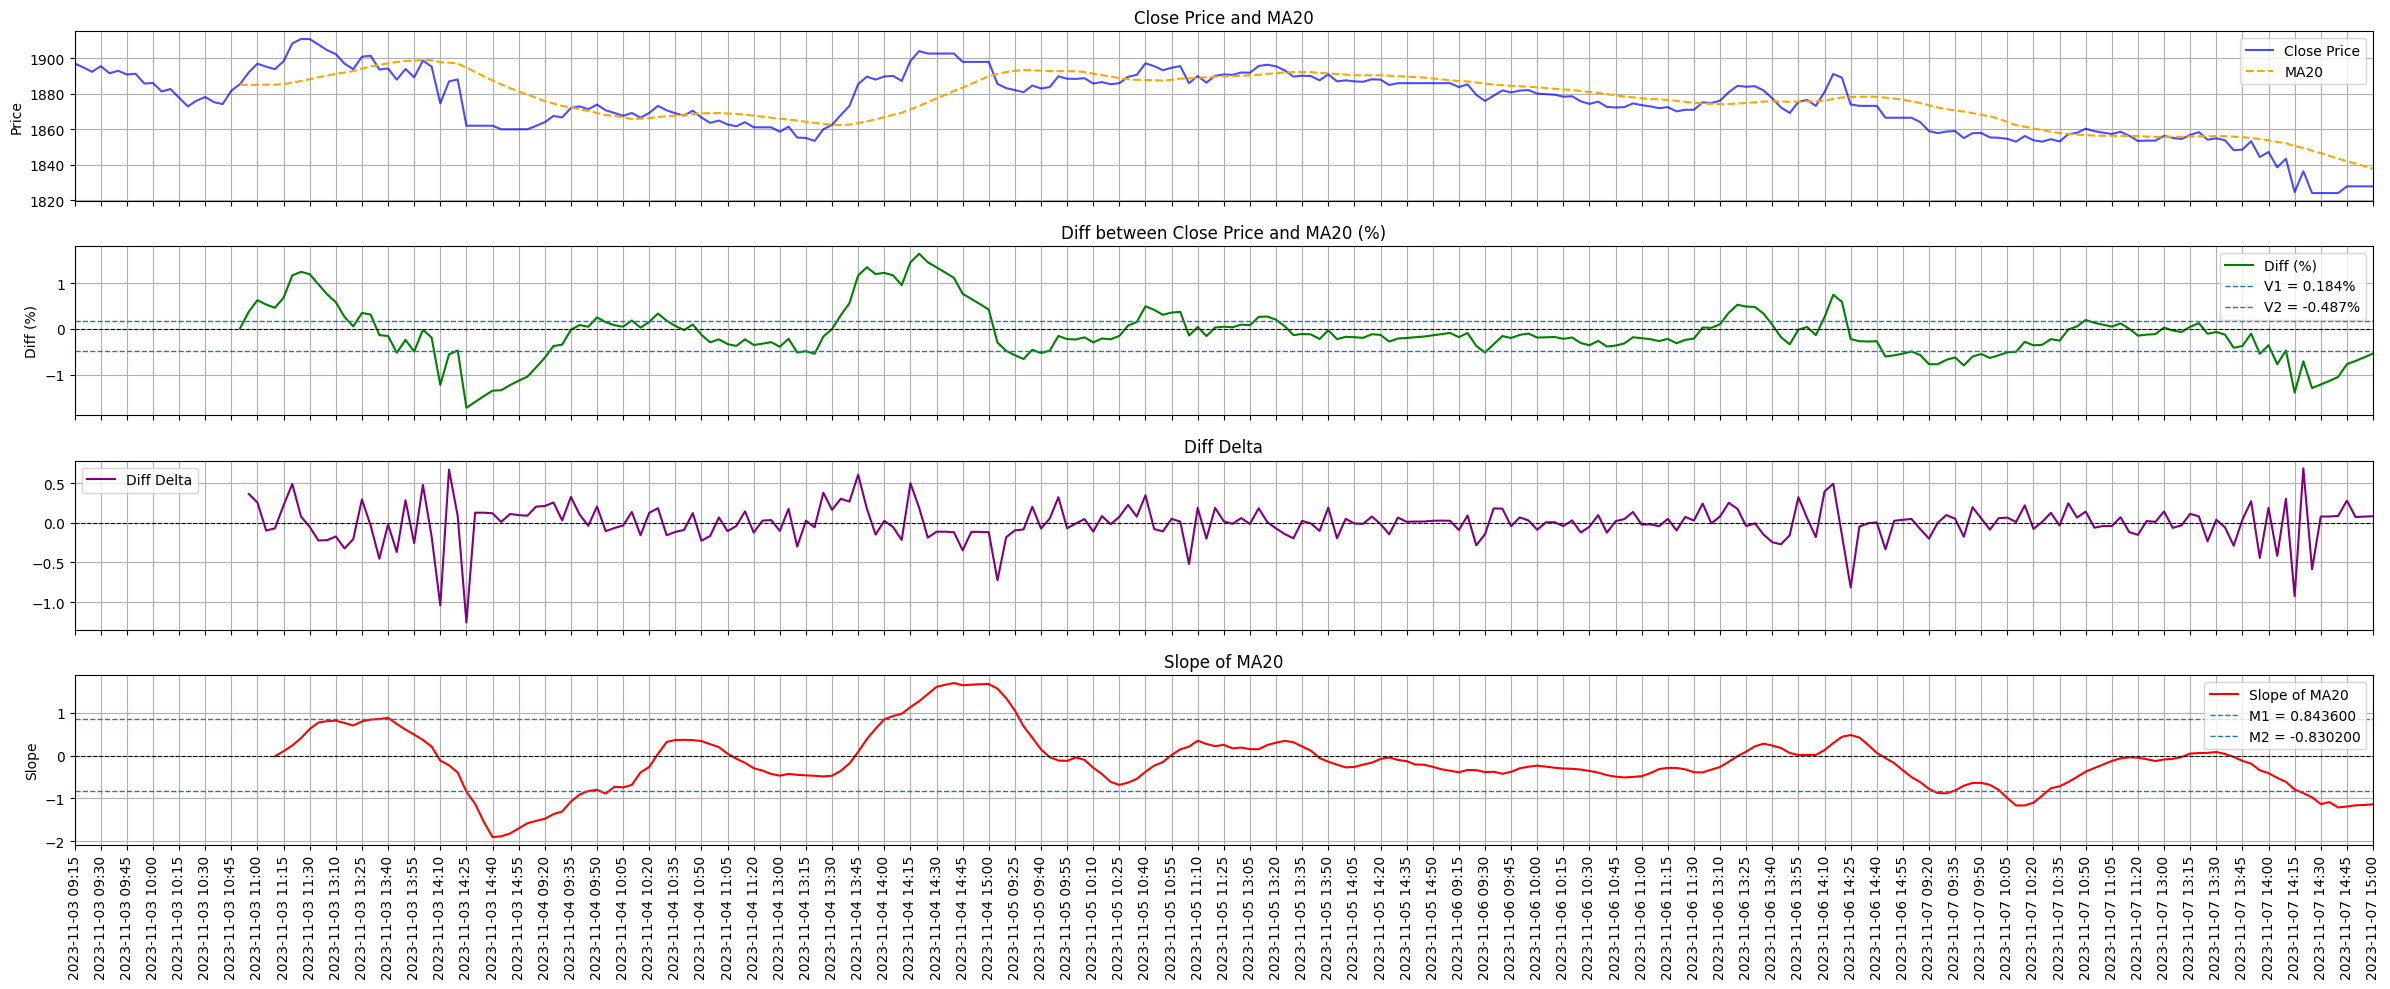

In [9]:
def plot_ma_charts(df: pd.DataFrame, *, tick_step: int = 1, bands: dict | None = None):
    if df is None or df.empty:
        return

    dfp = df.dropna(subset=["close"]).copy()
    if dfp.empty:
        return

    fig, axes = plt.subplots(4, 1, figsize=(24, 10), sharex=True)

    # x-axis: 0..N-1
    x = np.arange(len(dfp))
    tlabels = dfp.index.strftime("%Y-%m-%d %H:%M")

    # Chart 1: close Price and MA
    axes[0].plot(x, dfp["close"], label="Close Price", color="blue", alpha=0.7)
    axes[0].plot(x, dfp["ma20"], label="MA20", color="orange", linestyle="--", linewidth=1.5)
    axes[0].set_title("Close Price and MA20")
    axes[0].set_ylabel("Price")
    axes[0].legend()
    axes[0].grid(True)

    # Chart 2: Diff
    axes[1].plot(x, dfp["diff"], label="Diff (%)", color="green")
    axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)
    # ---- Add V1 / V2 lines ----
    if bands is not None:
        V1 = bands.get("V1", None)
        V2 = bands.get("V2", None)
        if V1 is not None:
            axes[1].axhline(V1, linestyle="--", linewidth=1.0, label=f"V1 = {V1:.3f}%")
        if V2 is not None:
            axes[1].axhline(V2, linestyle="--", linewidth=1.0, label=f"V2 = {V2:.3f}%")
    axes[1].set_title("Diff between Close Price and MA20 (%)")
    axes[1].set_ylabel("Diff (%)")
    axes[1].legend()
    axes[1].grid(True)

    # Chart 3: Diff_delta
    axes[2].plot(x, dfp["diff_delta"], label="Diff Delta", color="purple")
    axes[2].axhline(0, color="black", linestyle="--", linewidth=0.8)
    axes[2].set_title("Diff Delta")
    axes[2].legend()
    axes[2].grid(True)

    # Chart 4: Slope of MA20
    axes[3].plot(x, dfp["slope_ma20"], label="Slope of MA20", color="red")
    axes[3].axhline(0, color="black", linestyle="--", linewidth=0.8)
    # ---- Add M1 / M2 lines ----
    if bands is not None:
        M1 = bands.get("M1", None)
        M2 = bands.get("M2", None)
        if M1 is not None:
            axes[3].axhline(M1, linestyle="--", linewidth=1.0, label=f"M1 = {M1:.6f}")
        if M2 is not None:
            axes[3].axhline(M2, linestyle="--", linewidth=1.0, label=f"M2 = {M2:.6f}")
    axes[3].set_title("Slope of MA20")
    axes[3].set_ylabel("Slope")
    axes[3].legend()
    axes[3].grid(True)

    # ---- X ticks: ----
    tick_step = max(1, int(tick_step))
    tick_pos = np.arange(0, len(dfp), tick_step)

    axes[-1].set_xlim(0, len(dfp['close']) - 1)
    axes[-1].set_xticks(tick_pos)
    axes[-1].set_xticklabels(tlabels[tick_pos], rotation=90)

    plt.tight_layout()
    plt.show()

plot_ma_charts(df_5min, tick_step=3, bands=bands)

## <font color='blue'>**5. Run alpha**</font>


### <font color='green'>**5.1 Alpha function:**</font>

`ma_alpha()` produces a discrete signal:

- `1`  → long
- `-1` → short
- `0`  → flat

It defines:
- **Uptrend** and **Downtrend** regimes based on slope and price vs MA
- **Exit rules** using `V1/V2` and `M1/M2` (+ `near()` tolerance)
- Entry rules are allowed only when in the proper trend regime and not in an exit condition

In [10]:
def ma_alpha(
    df_chunk: pd.DataFrame,
    last_alpha: int,
    *,
    V1: float,
    V2: float,
    M1: float,
    M2: float
) -> int:
    if df_chunk is None or df_chunk.empty:
        return 0

    required = ("close", "ma20", "slope_ma20", "diff", "diff_delta")
    for c in required:
        if c not in df_chunk.columns:
            return 0

    # Use the latest available row (time t)
    last = df_chunk.iloc[-1]

    ma20 = last["ma20"]
    slope_ma20 = last["slope_ma20"]
    diff_now = last["diff"]
    diff_delta = last["diff_delta"]
    close_price = last["close"]

    # If indicators are not ready yet (NaN at the beginning), do nothing
    if pd.isna(ma20) or pd.isna(slope_ma20) or pd.isna(diff_now) or pd.isna(diff_delta):
        return 0

    slope_ma20 = float(slope_ma20)
    diff_now = float(diff_now)
    diff_delta = float(diff_delta)

    # Trend regime
    uptrend_cod1 = (slope_ma20 > M2)
    uptrend_cod2 = (slope_ma20 < 0.5 * (M1 + M2))
    uptrend_cod3 = (close_price > ma20)
    uptrend_cod4 = (diff_delta > 0)
    # The slope-MA20 value is located in the lower half of the range from M1 to M2.
    uptrend = uptrend_cod1 and uptrend_cod2 and uptrend_cod3 and uptrend_cod4 

    downtrend_cod1 = (slope_ma20 < M1)
    downtrend_cod2 = (slope_ma20 > 0.5 * (M1 + M2))
    downtrend_cod3 = (close_price < ma20)
    downtrend_cod4 = (diff_delta < 0)
    # The slope-MA20 value is located in the upper half of the range from M1 to M2.
    downtrend = downtrend_cod1 and downtrend_cod2 and downtrend_cod3 and downtrend_cod4 

    # Exit rules
    exit_long_cod1 = near(diff_now, V1) or (diff_now > V1)
    exit_long_cod2 = near(slope_ma20, M1) or (slope_ma20 > M1)
    exit_long_cod3 = (diff_now > 0.5 * (V1 + V2)) and (slope_ma20 > M1)
    exit_long = exit_long_cod1 or exit_long_cod2 or exit_long_cod3

    exit_short_cod1 = near(diff_now, V2) or (diff_now < V2)
    exit_short_cod2 = near(slope_ma20, M2) or (slope_ma20 < M2)
    exit_short_cod3 = (diff_now < 0.5 * (V1 + V2)) and (slope_ma20 < M1)
    exit_short = exit_short_cod1 or exit_short_cod2 or exit_short_cod3

    # Long entry logic
    if uptrend:
        if exit_long:
            return 0
        if (slope_ma20 > M2) and (slope_ma20 < 0.5 * (M1 + M2)) and last_alpha != -1:
            return 1
        return 0

    # Short entry logic
    if downtrend:
        if exit_short:
            return 0
        if (slope_ma20 < M1) and (slope_ma20 > 0.5 * (M1 + M2)) and last_alpha != 1:
            return -1
        return 0

    return last_alpha

### <font color='green'>**5.2 Run MA alpha:**</font>

`run_alpha()` iterates bar-by-bar, and for each bar:

1. Builds a **chunk** `ticks.loc[:t]` for indicator evaluation
2. Slices the last **tf window** (e.g. 5 minutes) for stop-loss check
3. If currently holding a position, computes **PnL points** and compares to `loss_range`
4. If not stopped out, calls `ma_alpha()` to compute the new signal
5. Tracks `entry_price` when opening a position

Returns:
- `signals`: array of positions over time
- `prices`: close prices used
- `index`: timestamps

In [11]:
def run_alpha(
    ticks: pd.DataFrame,
    *,
    bands: dict,
    loss_range: float = -5.0
) -> tuple[np.ndarray, np.ndarray, pd.DatetimeIndex]:
    bar_close = ticks['close']

    signals = []
    prices = []

    last_alpha = 0
    entry_price = 0.0

    for t, close in bar_close.items():
        chunk = ticks.loc[:t]

        # Ticks of 5-minute bars
        bar_start = t - pd.Timedelta(tf)
        bar_ticks = ticks.loc[bar_start:t]

        # Stop-loss check
        if last_alpha != 0 and entry_price is not None:
            if not bar_ticks.empty:
                check_price = float(bar_ticks['close'].min()) if last_alpha == 1 else float(bar_ticks['close'].max())
            else:
                check_price = float(close)

            # pnl_points = check_price - entry_price
            pnl_points = (check_price - entry_price) * last_alpha
            if pnl_points < loss_range:
                current_alpha = 0
                entry_price = None
            else:
                current_alpha = None
        else:
            current_alpha = None

        # If not stopped, calculate alpha
        if current_alpha is None:
            current_alpha = ma_alpha(chunk, last_alpha, **bands)

            if last_alpha == 0 and current_alpha != 0:
                entry_price = float(close)
            elif last_alpha != 0 and current_alpha == 0:
                entry_price = None
        
        signals.append(int(current_alpha))
        prices.append(float(close))
        last_alpha = int(current_alpha)
    
    return np.array(signals), np.array(prices), bar_close.index

signals, prices, idx = run_alpha(df_5min, bands=bands, loss_range=-5.0)

## <font color='blue'>**6. PnL Calculation**</font>

PnL is computed from position changes and price differences:

- `prev_position` = position shifted by 1 (position held during the price move)
- `gross_pnl` = price_diff × prev_position
- `net_pnl` = gross_pnl - transaction_fee (only when gross_pnl != 0)
- `sum_pnl` = cumulative sum of net_pnl

Then the PnL columns are joined back into `df_5min` and exported to CSV.

In [12]:
def calculate_pnl(df_5min, bar_close_index: pd.DatetimeIndex , alpha_signals: np.ndarray, price_history: np.ndarray, transaction_fee: float = 0.4) -> float:
        dfp = pd.DataFrame({"Index": bar_close_index, "close_price": price_history, "position": alpha_signals})
        dfp["prev_position"] = dfp["position"].shift(1).fillna(0)
        dfp["price_diff"] = dfp["close_price"].diff().fillna(0)

        dfp["gross_pnl"] = dfp["price_diff"] * dfp["prev_position"]
        dfp["net_pnl"] = np.where(
            dfp['gross_pnl'] != 0,
            dfp['gross_pnl'] - transaction_fee,
            0.0
        )
        dfp["sum_pnl"] = dfp["net_pnl"].cumsum()

        cols_to_add = [
            "position",
            "prev_position",
            "price_diff",
            "gross_pnl",
            "net_pnl",
            "sum_pnl",
        ]
        df_5min = df_5min.join(
            dfp.set_index("Index")[cols_to_add],
            how="left"
        )
        df_5min.to_csv("../data/processed/pnl_details.csv")

        return float(dfp["sum_pnl"].iloc[-1]), df_5min

pnl, pnl_df = calculate_pnl(df_5min, idx, signals, prices, transaction_fee=0.4)

In [13]:
pnl

12.100000000000266

In [14]:
pnl_df

,open,high,low,close,ma20,slope_ma20,diff,diff_delta,position,prev_position,price_diff,gross_pnl,net_pnl,sum_pnl
time_stamp,,,,,,,,,,,,,,
2023-11-03 09:15:00,1894.6,1899.9,1894.4,1897.1,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,0.0
2023-11-03 09:20:00,1897.1,1898.1,1894.4,1894.9,NaN,NaN,NaN,NaN,0,0.0,-2.2,-0.0,0.0,0.0
2023-11-03 09:25:00,1894.9,1895.0,1890.7,1892.4,NaN,NaN,NaN,NaN,0,0.0,-2.5,-0.0,0.0,0.0
2023-11-03 09:30:00,1892.4,1897.0,1891.7,1895.6,NaN,NaN,NaN,NaN,0,0.0,3.2,0.0,0.0,0.0
2023-11-03 09:35:00,1895.6,1896.5,1891.5,1891.6,NaN,NaN,NaN,NaN,0,0.0,-4.0,-0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-07 14:40:00,1824.0,1824.0,1824.0,1824.0,1843.395,-1.209,-1.052135,0.086612,-1,-1.0,0.0,-0.0,0.0,16.3
2023-11-07 14:45:00,1824.0,1827.8,1824.0,1827.8,1842.030,-1.188,-0.772517,0.279618,-1,-1.0,3.8,-3.8,-4.2,12.1
2023-11-07 14:50:00,1827.8,1827.8,1827.8,1827.8,1840.695,-1.159,-0.700551,0.071967,-1,-1.0,0.0,-0.0,0.0,12.1
